# Autoencoders and Generative Adversarial Networks - Part 3/3
### XX Seminar on Software for Nuclear, Subnuclear and Applied Physics, 4-9 June 2023, Hotel Porto Conte, Maristella SS, IT

Contacts: 
 * email: Lucio.Anderlini [at] fi.infn.it
 * GitHub: [github.com/landerlini](https://github.com/landerlini)

## Generative Adversarial Networks and conditioning

In this notebook we will focus on using autoencoders as generative models. We will define the concept of conditioning and we will introduce an alternative System of Neural Networks, Generative Adversarial Networks.

## Setting the scene

Let's copy-paste from the previous lecture the steps of data pre-processing and the `rough_inspection` function.


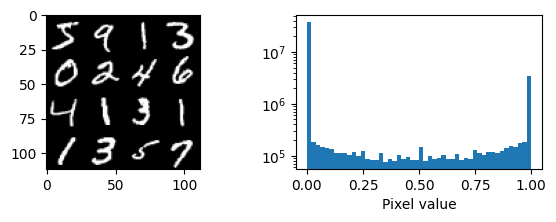

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

def rough_inspection(dataset, n_fig=4):
    figure = np.concatenate([np.reshape(dataset[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)

    plt.figure(figsize=(7,2))
    plt.subplot(1, 2, 1)
    plt.imshow(figure, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(dataset.flatten(), bins=50)
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.show()
    
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_idx = sum([np.arange(len(y_train))[y_train == i].tolist()[:4] for i in range(10)], [])
test_idx = sum([np.arange(len(y_test))[y_test == i].tolist()[:4] for i in range(10)], [])

Lx_train = x_train[train_idx]
Lx_test = x_test[test_idx]
Ly_train = y_train[train_idx]
Ly_test = y_test[test_idx]

px_train = (x_train / x_train.max())
px_test = (x_test / x_train.max()) 
pLx_train = (Lx_train / x_train.max())
pLx_test = (Lx_test / x_train.max()) 

py_train = np.stack([y_train == i for i in range(10)], axis=1)
py_test = np.stack([y_test == i for i in range(10)], axis=1)

rough_inspection(px_train)

## Autoencoders as Generators

Let's restart from our example of autoencoder with pinned labels in the latent space.
Let's define a slightly deeper network.

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam


encoder = Sequential([
    Reshape((28, 28, 1)),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(2, activation='linear')
])

encoder.build(input_shape=(None, 28, 28))
display(encoder.summary())

decoder = Sequential([
    Dense(32, activation='tanh'),
    Dense(28//4*28//4, activation='tanh'),
    Reshape((28//4, 28//4, 1)),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(8, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(1, kernel_size=(2, 2), padding='same', activation='sigmoid'),
    Reshape((28,28)),
])
decoder.build(input_shape=encoder.output_shape)

display(decoder.summary())

2023-06-04 16:08:10.515666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 16:08:10.533935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 16:08:10.535588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2320      
                                                        

2023-06-04 16:08:10.538589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 16:08:10.540127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 16:08:10.541717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 16:08:10.543306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                96        
                                                                 
 dense_4 (Dense)             (None, 49)                1617      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         160       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 32)         4128      
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)      

None

  0%|          | 0/30 [00:00<?, ?it/s]2023-06-04 16:08:12.204591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-06-04 16:08:13.692875: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 30/30 [01:50<00:00,  3.70s/it]


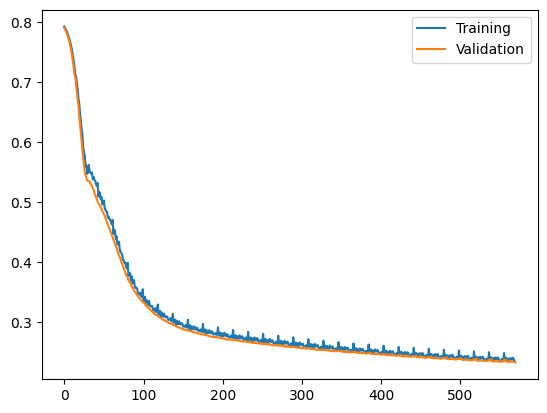

In [3]:
ae_optimizer = Adam(1e-3)

def ae_train_step(train_data, labels):
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights

    ae_vars = enc_vars + dec_vars

    with tf.GradientTape() as tp:
        encoded = encoder(train_data)
        decoded = decoder(encoded)

        pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
        labeled_loss = tf.reduce_mean(
            tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
        )
        
        loss = BinaryCrossentropy()(train_data, decoded) + 0.1*labeled_loss

    ae_grads = tp.gradient(loss, ae_vars)
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

    return loss

def ae_test_step(test_data, labels):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
    labeled_loss = tf.reduce_mean(
        tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
    )
        
    loss = BinaryCrossentropy()(test_data, decoded) + 0.1*labeled_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 20)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(y_train, 20)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(y_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(30):
    for chunk, label_chunk in zip(chunks, label_chunks):
        losses.append(ae_train_step(chunk, label_chunk))
        val_losses.append(ae_test_step(val_chunk, val_label))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

Now we can sample the latent space with random points selected around the pin for a specific point and use the decoder to "generate" a new image from that point.

In this way we can generate new digits, never actually "seen" by the autoencoder but ***conditioned*** in the sense we introduce a condition on the generation (in this case the label).

2/2 [==============================] - 0s 3ms/step


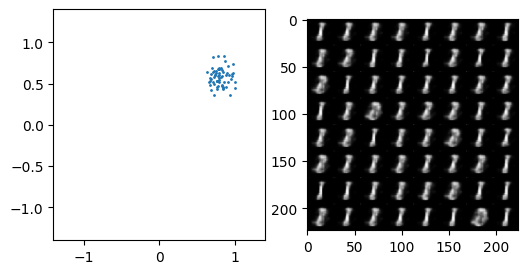

In [4]:
def test_digit(digit, decoder_net, n_fig=8):
    label = np.c_[np.cos(2*np.pi*digit/10), np.sin(2*np.pi*digit/10)]
    encoded = np.random.normal(label, 0.1, (n_fig*n_fig, 2))
    plt.figure(figsize=(6,3))
    plt.subplot(1, 2, 1)
    plt.scatter(encoded[:,0], encoded[:, 1], s=1)
    plt.ylim(-1.4, 1.4)
    plt.xlim(-1.4, 1.4)
    
    decoded = decoder_net.predict(encoded)
    figure = np.concatenate([np.reshape(decoded[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)
    plt.subplot(1, 2, 2)
    plt.imshow(figure, cmap='gray')

test_digit(1, decoder)

2/2 [==============================] - 0s 3ms/step


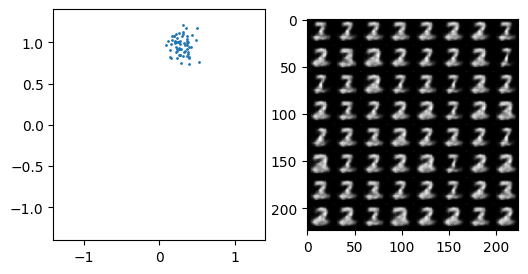

In [5]:
test_digit(2, decoder)

2/2 [==============================] - 0s 4ms/step


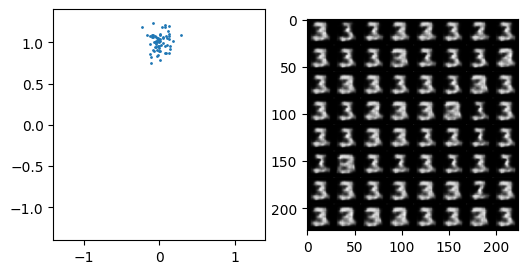

In [6]:
test_digit(2.5, decoder)

2/2 [==============================] - 0s 2ms/step


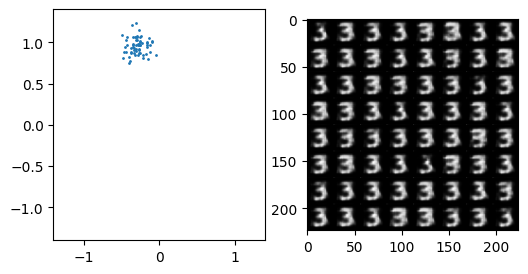

In [7]:
test_digit(3, decoder)

Observing the generated digits we notice they are all very similar to each other. The decoder is not really representing the variability of possible digits we have in the training sample. This happens, again, because there is not a notion of probability on the generated sample, so even one single image capable of minimizing the loss function for all digit would be (possibly local) minimum of the loss function.

We learned that we can use an adversial approach to introduce the notion of distribution in the training loop. Let's try to do the same thing (though in a much more abstract way) imposing a distribution to the space of the generated images instead of setting the distribution in the latent space.

# Generative Adversarial Networks (GANs)

Actually, we can completely drop the encoder part and keep only the *decoder*, now named **generator** taking as an input randomly generated entries in the latent space.
Then, we will redefine the adversarial classifier which was trying to classify encoded features vs. randomly generated entries in the encoded space with a new classifier, named **discriminator** trying to classify images in the training sample vs. generated images.

As done for the adversarial autoencoder, we will try to maximize the loss of the discriminator tuning the weights of the **generator**, forcing it to generate images with a **probability distribution** indistinguishable from that of the input images.

Generative adversarial networks (GANs) are a powerful framework for learning generative models from data. A GAN consists of two neural networks: a generator that produces synthetic data from a random input, and a discriminator that tries to distinguish between real and fake data. The generator and the discriminator are trained in an adversarial manner, where the generator tries to fool the discriminator and the discriminator tries to correctly classify the data. The goal of the GAN is to find a Nash equilibrium where the generator produces realistic data and the discriminator cannot tell them apart from the real data.

In [8]:
## The generator is a simplified version of the DECODER defined in the previous notebooks
generator = Sequential([
    Flatten(),
    Dense(7*7*8, activation='tanh'),
    Reshape((7, 7, 8)),
    Conv2DTranspose(8, kernel_size=(3,3), activation='tanh', padding='same'),
    UpSampling2D(size=(2,2)),
    Conv2DTranspose(16, kernel_size=(3,3), activation='tanh', padding='same'),
    UpSampling2D(size=(2,2)),
    Conv2DTranspose(1, kernel_size=(3,3), activation='sigmoid', padding='same'),
    Reshape((28, 28))
])
generator.build(input_shape=(None, 28, 28, 1))

display(generator.summary())


## The discriminator is a classifier taking images as input (and then we can use effectively convolutional layers)
## and generating a boolean output: 1 if the image is generated or 0 if it is sampled from the training dataset
discriminator = Sequential([
    Reshape((28, 28, 1)),
    Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(1e-3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(1e-3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(4, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(1e-3)),
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')
])

discriminator.build(input_shape=(None, 28, 28))
display(discriminator.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 392)               307720    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 8)          584       
 ranspose)                                                       
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 14, 14, 16)      

None

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 4)          

None

### Training loop
The training loop is very similar to what we discussed for the adversarial autoencoders.
Here we are adopting some trick to stabilize the adversarial training.

Making adversarial training stable and successful is an entier field of research. 
At the time of writing, the state of the art is probably the [GigaGAN](https://mingukkang.github.io/GigaGAN/) combining convolutional and self-attention layers in both the generator and the discriminator to ensure better "flowing" of the gradients while training.

100%|██████████| 100/100 [10:12<00:00,  6.12s/it]


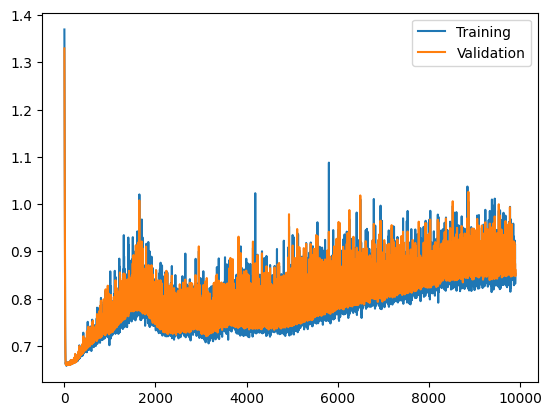

In [9]:
from tensorflow.keras.optimizers import RMSprop

## We are using now two different optimizers the generator and the discriminator
## We favour RMSprop over Adam because it follows smoother paths than Adam, 
## which may break the equilibrium between the two players.
g_optimizer = RMSprop(1e-4)
d_optimizer = RMSprop(5e-4)

def train_step (data):
    g_vars = generator.trainable_weights
    d_vars = discriminator.trainable_weights
    
    ## Two gradient tapes are defined for the two networks
    with tf.GradientTape() as g_tp, tf.GradientTape() as d_tp:
        
        ## Forward pass:
        ## 1. generate the images 
        generated = generator(tf.random.normal(data.shape))
        ## 2. apply the discriminator to the generated figures
        d_gen = discriminator(generated)
        ## 3. apply the discriminator to the real data
        d_ref = discriminator(data)
        
        ## Compute the loss of the discriminator as a simple cross-entropy
        n = tf.shape(d_gen)[0]
        d_loss = (
            BinaryCrossentropy()(tf.fill(n, 0.9), d_gen) + 
            BinaryCrossentropy()(tf.fill(n, 0.1), d_ref)
        )
        
        ## Define the loss function of the generator
        g_loss = -d_loss
        
    ## Then apply the usual scheme to compute and apply gradients
    g_grads = g_tp.gradient(g_loss, g_vars)
    d_grads = d_tp.gradient(d_loss, d_vars)
    
    g_optimizer.apply_gradients(zip(g_grads, g_vars))
    d_optimizer.apply_gradients(zip(d_grads, d_vars))

    return d_loss
    
def test_step (data):
    generated = generator(tf.random.normal(data.shape))
    d_gen = discriminator(generated)
    d_ref = discriminator(data)
    
    n = tf.shape(data)[0]
        
    loss = (
        BinaryCrossentropy()(tf.fill(n, 0.9), d_gen) + 
        BinaryCrossentropy()(tf.fill(n, 0.1), d_ref)
    )
        
    return loss


losses = []
val_losses = []

losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 100)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(y_train, 100)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(y_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
generator = clone_model(generator)
discriminator = clone_model(discriminator)

from tqdm import trange
for epoch in trange(100):
    for chunk in chunks:
        losses.append(train_step(chunk))
        val_losses.append(test_step(val_chunk))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

### Comments on the loss evolution
Reading the loss of an Adversarial network is difficult. A high value of the loss may indicate both that the generator is excellent reproducing the original dataset or that the discriminator is extremely bad at classifying entries.

### Let's visualize the generated images.

2/2 [==============================] - 0s 2ms/step


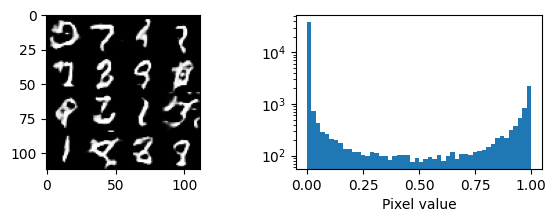

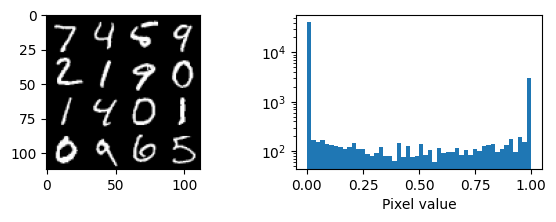

In [10]:
generated = generator.predict(np.random.normal(0, 1, (64, 28, 28)))
rough_inspection(generated)
rough_inspection(val_chunk.numpy()[:64])

We observe they are somewhat similar to digits, or letters, but they do not really make sense.
The generator has no notion of what a digit is and digit a rather different from each other that it is "inventing" new digits. 
This is the extreme opposite of the behaviour we discussed above for autoencoders.

Both effects can be mitigated by using more complex neural networks, better loss functions and longer trainings, but the conceptual difference between the solution of an autoencoder and that of a GAN remains. **GANs** are generally more "creative" than the autoencoders used as generators, but Autoencoders are so much easier to train, that sometimes they are still preferred over GANs.

# Conditioning a GAN

As we have conditioned the generation of digits from the decoder, defining a properly shaped noise function, here we try to modify the behaviour of the generator using a condition (once again, the label of the digit).

In general, a conditional GAN (cGAN) is a type of GAN that can generate images conditioned on some additional information, such as class labels, text descriptions, or other modalities. A cGAN still consists of two neural networks: a generator that produces synthetic images from a random input and a conditional input, and a discriminator that tries to distinguish between real and fake images given the same conditional input. The conditional input can be concatenated with the random input for the generator, and with the image input for the discriminator. The goal of the cGAN is to find a Nash equilibrium where the generator produces realistic data that match the conditional input, and the discriminator cannot tell them apart from the real dataset.

A cGAN can have various applications, such as image-to-image translation, image inpainting, text-to-image synthesis, and style transfer. A cGAN can also improve the quality and diversity of the generated images compared to an unconditional GAN, since it can leverage the additional information to guide the generation process.

To condition the GAN we will need to rewrite a bit of out computation graph. We will still have at the core of the algorithm two CNNs, but now the input of the generator has to be the label and the discriminator must take a concatenation of the generated image and some representation of the label.

> **Hint.** We are using a LeakyReLU loss function which reduces problems connected to gradient vanishing. 

In [11]:
from tensorflow import keras as K
from tensorflow.keras.layers import LeakyReLU

## This represents the generator inputs: the label and 
label = K.Input(10, dtype=tf.float32, name="label")/10 - 0.5
noise = tf.random.normal((tf.shape(label)[0], 64), 0., 1., name="noise")

## Then we concatenate the noise and the one-hot encoded label
labeled_noise = K.layers.Concatenate(axis=1)((label, noise))

## We define our generator architecture as a CNN similar to our former decoder
generator_dnn = Sequential([
    Dense(7*7*6, activation='linear', kernel_initializer='he_normal'),
    LeakyReLU(),
    Reshape((7, 7, 6)),
    Conv2DTranspose(32, kernel_size=(3,3), activation='linear', padding='same'),
    LeakyReLU(),
    UpSampling2D(size=(2,2)),
    Conv2DTranspose(16, kernel_size=(3,3), activation='linear', padding='same'),
    LeakyReLU(),
    UpSampling2D(size=(2,2)),
    K.layers.Rescaling(10., offset=-5),
    Conv2DTranspose(1, kernel_size=(3,3), activation='sigmoid', padding='same'),
    Reshape((28, 28))
], name="generator_cnn")

## We apply the generator to our preprocessed, concatenated input
generated = generator_dnn(labeled_noise)

## We define the generator model identifying its inputs and outputs
generator = K.models.Model(inputs=label, outputs=generated, name="generator")

display(generator.summary())

#######
## Let's start with the discriminator, now

## The discriminator's input is a 28x28 image, either generated or picked from 
## the reference sample.
generated_or_reference = K.Input((28, 28), dtype=tf.float32, name="gen_or_ref")

## To be able to concatenate the labels to the images, we need to reshape the 
## labels to match a 28x28 grayscale image, let's do it with a shallow network
label_mapper = Sequential([
    Dense(28*28, activation='sigmoid'),
    Reshape((28, 28, 1))
], name="label_mapper")

## Then we concatenate the mapped lables with the 28x28 images
labeled_generated = K.layers.Concatenate(axis=-1)((label_mapper(label), generated_or_reference[..., None]))

## Let's define the discriminator, with an architecture similar to that of our encoder
## it should read an image and output a classifier: 1 if the image is generated, or 0 if it is obtained from a reference sample
discriminator_dnn = Sequential([
    Conv2D(16, kernel_size=(5,5), activation='linear', padding='same', kernel_regularizer=L2(1e-3)),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(8, kernel_size=(5,5), activation='linear', padding='same', kernel_regularizer=L2(1e-3)),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(4, kernel_size=(5,5), activation='linear', padding='same', kernel_regularizer=L2(1e-3)),
    LeakyReLU(),
    Flatten(),
    Dense(64, activation='linear', kernel_initializer='he_normal'),
    LeakyReLU(),
    Dense(1, activation='sigmoid')
], name="discriminator_cnn")

## We describe the forward pass 
classifier = discriminator_dnn(labeled_generated)

## And then we define the model identifying who is the input and who is the output
discriminator = K.models.Model(inputs=(label, generated_or_reference), outputs=classifier, name="discriminator")

display(discriminator.summary())


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[1][0]']     
 ingOpLambda)                                                                                     
                                                                                          

None

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 gen_or_ref (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 label_mapper (Sequential)      (None, 28, 28, 1)    8624        ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 28, 28, 1)   0           ['gen_or_ref[0][0]']             
 icingOpLambda)                                                                       

None

The forward pass is rather similar the one we have discussed above and in previous lectures.

100%|██████████| 100/100 [14:15<00:00,  8.55s/it]


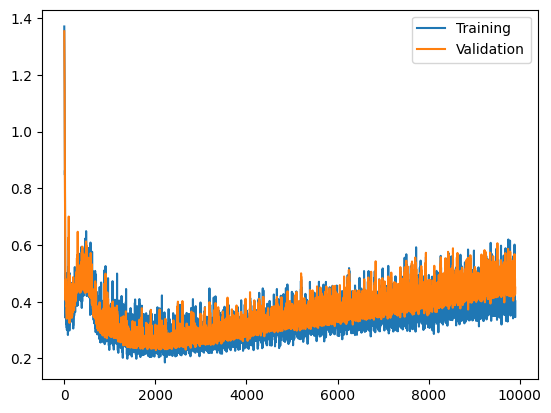

In [12]:
g_optimizer = Adam(1e-4)
d_optimizer = Adam(5e-4)

def train_step (data, label):
    g_vars = generator.trainable_weights
    d_vars = discriminator.trainable_weights
    
    with tf.GradientTape() as g_tp, tf.GradientTape() as d_tp:
        generated = generator(label)
        d_gen = discriminator((label, generated))
        d_ref = discriminator((label, data))
        n = tf.shape(d_gen)[0]
        d_loss = (
            BinaryCrossentropy()(tf.fill(n, 0.99), d_gen) + 
            BinaryCrossentropy()(tf.fill(n, 0.01), d_ref)
        )
        g_loss = -d_loss
        
    g_grads = g_tp.gradient(g_loss, g_vars)
    d_grads = d_tp.gradient(d_loss, d_vars)

    g_optimizer.apply_gradients(zip(g_grads, g_vars))
    d_optimizer.apply_gradients(zip(d_grads, d_vars))

    return d_loss
    
def test_step (data, label):
    generated = generator(label)
    d_gen = discriminator((label, generated))
    d_ref = discriminator((label, data))
    
    n = tf.shape(data)[0]
        
    loss = (
        BinaryCrossentropy()(tf.fill(n, 0.99), d_gen) + 
        BinaryCrossentropy()(tf.fill(n, 0.01), d_ref)
    )
        
    return loss


losses = []
val_losses = []


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 100)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(py_train, 100)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(py_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
generator = clone_model(generator)
discriminator = clone_model(discriminator)

from tqdm import trange
for epoch in trange(100):
    for chunk, labels in zip(chunks, label_chunks):
        losses.append(train_step(chunk, labels))
        val_losses.append(test_step(val_chunk, val_label))
        
plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

But now we are able to request generated digits from a given family and obtain a sample of 1, 2, ...

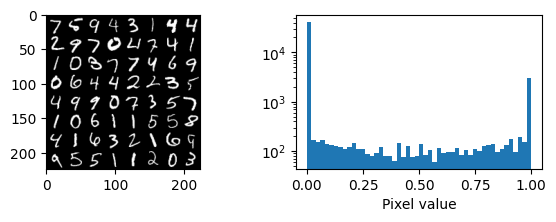

2/2 [==============================] - 0s 3ms/step


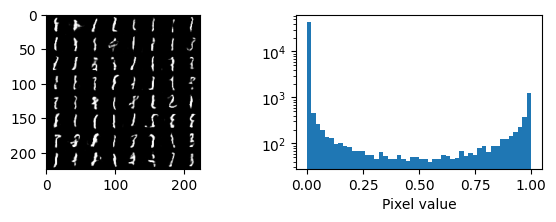

2/2 [==============================] - 0s 2ms/step


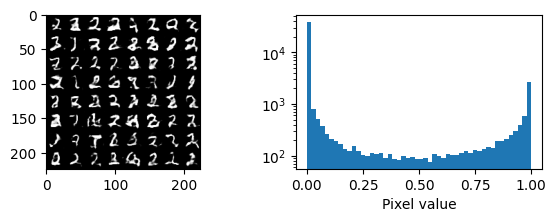

2/2 [==============================] - 0s 2ms/step


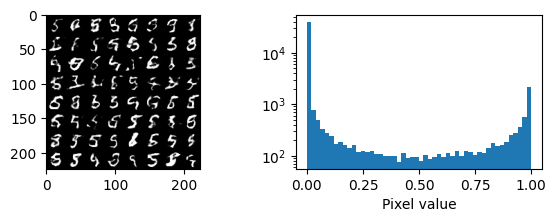

In [13]:
rough_inspection(val_chunk.numpy()[:64], n_fig=8)

for example_digit in 1, 2, 5:
    generated = generator.predict([[i==example_digit for i in range(10)] for _ in range(64)])
    rough_inspection(generated, n_fig=8)


# Conclusion

In this notebook we extended the concept of Systems of Neural Networks to train a network as a generator of samples, images in this case, possibly based on some condition. 
Generators of samples are widely used in High Energy Physics to replace (parts of) the Geant4-based simulation with parametrizations that embed the intrinsic randomicity of the quantum processes that Geant4 simulates in probabilistic representations.

For a survey on applications of Generative Models to Particle Physics, scroll down to "Generative models / density estimation" in the [HEPML Living Review](https://iml-wg.github.io/HEPML-LivingReview/).